In [75]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_dat_file
import matplotlib.pyplot as plt


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [76]:
# LSTM-Modell Klasse
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.001):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        # Erwartet: (Batch, SeqLen, Features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # letzter Zeitschritt
        out = self.fc(out)
        return out

    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch

        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_model(self, train_loader, epochs):
        all_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_loss = total_loss / len(train_loader)
            all_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        # Neu: Plotte die Losse danach
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), all_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Average Training Loss")
        plt.title("LSTM Training Loss")
        plt.grid(True)
        plt.show()
        return all_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    def save_model(self,path):
        torch.save(self.state_dict(), path)

    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))
        

In [77]:
# Datenvorbereitung

file = r"gas+sensor+array+drift+dataset/Dataset/batch1.dat"
df = load_dat_file(file)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge 
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cpu
Epoch [1/30], Loss: 1.7729
Epoch [2/30], Loss: 1.7194
Epoch [3/30], Loss: 1.6792
Epoch [4/30], Loss: 1.6487
Epoch [5/30], Loss: 1.6111
Epoch [6/30], Loss: 1.5809
Epoch [7/30], Loss: 1.5423
Epoch [8/30], Loss: 1.5089
Epoch [9/30], Loss: 1.4626
Epoch [10/30], Loss: 1.4212
Epoch [11/30], Loss: 1.3723
Epoch [12/30], Loss: 1.3308
Epoch [13/30], Loss: 1.2814
Epoch [14/30], Loss: 1.2327
Epoch [15/30], Loss: 1.1856
Epoch [16/30], Loss: 1.1415
Epoch [17/30], Loss: 1.0995
Epoch [18/30], Loss: 1.0502
Epoch [19/30], Loss: 1.0168
Epoch [20/30], Loss: 0.9770
Epoch [21/30], Loss: 0.9410
Epoch [22/30], Loss: 0.9073
Epoch [23/30], Loss: 0.8779
Epoch [24/30], Loss: 0.8446
Epoch [25/30], Loss: 0.8153
Epoch [26/30], Loss: 0.7914
Epoch [27/30], Loss: 0.7626
Epoch [28/30], Loss: 0.7386
Epoch [29/30], Loss: 0.7236
Epoch [30/30], Loss: 0.7026


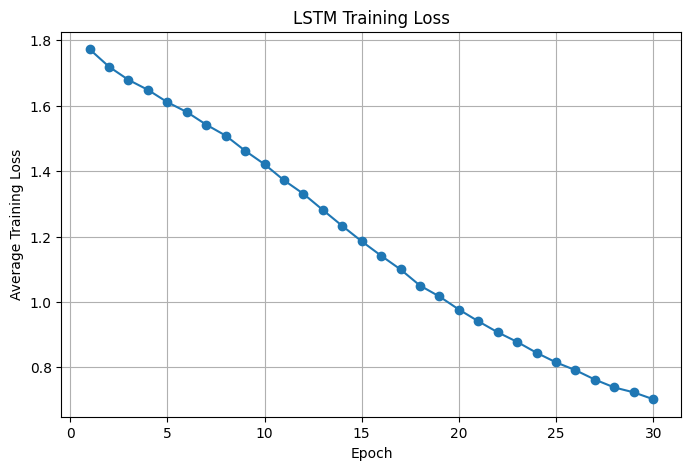

Test Accuracy: 0.8750


In [78]:
# Training starten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
model.to(device)

# Trainieren
model.train_model(train_loader, epochs=30)

# Evaluieren
model.evaluate(test_loader)

# speichern
model.save_model("lstm_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30], Loss: 1.7779
Epoch [2/30], Loss: 1.6768
Epoch [3/30], Loss: 1.5685
Epoch [4/30], Loss: 1.4498
Epoch [5/30], Loss: 1.3125
Epoch [6/30], Loss: 1.1632
Epoch [7/30], Loss: 1.0241
Epoch [8/30], Loss: 0.8950
Epoch [9/30], Loss: 0.7897
Epoch [10/30], Loss: 0.7019
Epoch [11/30], Loss: 0.6203
Epoch [12/30], Loss: 0.5578
Epoch [13/30], Loss: 0.4997
Epoch [14/30], Loss: 0.4588
Epoch [15/30], Loss: 0.4195
Epoch [16/30], Loss: 0.3750
Epoch [17/30], Loss: 0.3380
Epoch [18/30], Loss: 0.3096
Epoch [19/30], Loss: 0.2891
Epoch [20/30], Loss: 0.2655
Epoch [21/30], Loss: 0.2488
Epoch [22/30], Loss: 0.2355
Epoch [23/30], Loss: 0.2342
Epoch [24/30], Loss: 0.2272
Epoch [25/30], Loss: 0.2039
Epoch [26/30], Loss: 0.2055
Epoch [27/30], Loss: 0.1796
Epoch [28/30], Loss: 0.1782
Epoch [29/30], Loss: 0.1734
Epoch [30/30], Loss: 0.1685


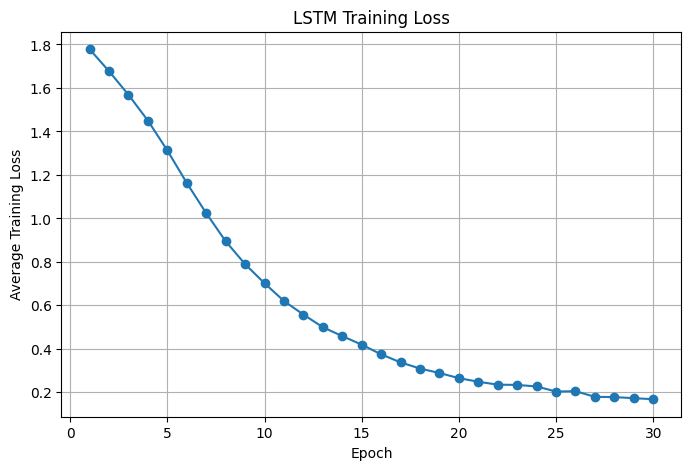

Test Accuracy: 0.9750

--- Fold 2/5 ---
Epoch [1/30], Loss: 1.8200
Epoch [2/30], Loss: 1.6979
Epoch [3/30], Loss: 1.5885
Epoch [4/30], Loss: 1.4653
Epoch [5/30], Loss: 1.3274
Epoch [6/30], Loss: 1.1810
Epoch [7/30], Loss: 1.0433
Epoch [8/30], Loss: 0.9182
Epoch [9/30], Loss: 0.8100
Epoch [10/30], Loss: 0.7186
Epoch [11/30], Loss: 0.6348
Epoch [12/30], Loss: 0.5598
Epoch [13/30], Loss: 0.4893
Epoch [14/30], Loss: 0.4401
Epoch [15/30], Loss: 0.3978
Epoch [16/30], Loss: 0.3550
Epoch [17/30], Loss: 0.3310
Epoch [18/30], Loss: 0.2977
Epoch [19/30], Loss: 0.2799
Epoch [20/30], Loss: 0.2610
Epoch [21/30], Loss: 0.2478
Epoch [22/30], Loss: 0.2281
Epoch [23/30], Loss: 0.2125
Epoch [24/30], Loss: 0.1988
Epoch [25/30], Loss: 0.1810
Epoch [26/30], Loss: 0.1920
Epoch [27/30], Loss: 0.1694
Epoch [28/30], Loss: 0.1640
Epoch [29/30], Loss: 0.1504
Epoch [30/30], Loss: 0.1456


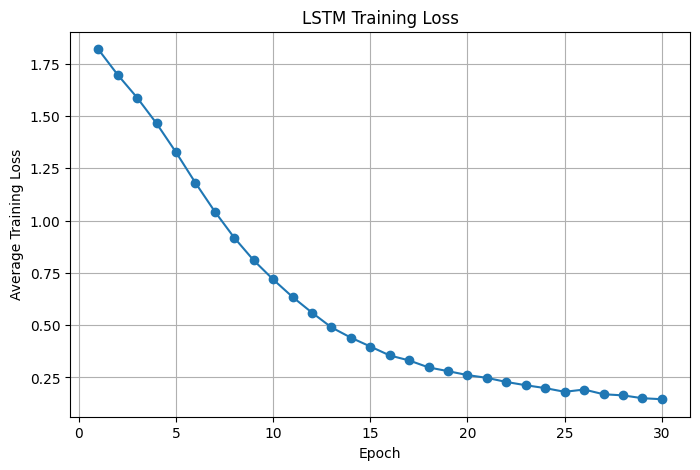

Test Accuracy: 0.9747

--- Fold 3/5 ---
Epoch [1/30], Loss: 1.7370
Epoch [2/30], Loss: 1.6442
Epoch [3/30], Loss: 1.5480
Epoch [4/30], Loss: 1.4334
Epoch [5/30], Loss: 1.3061
Epoch [6/30], Loss: 1.1727
Epoch [7/30], Loss: 1.0376
Epoch [8/30], Loss: 0.9116
Epoch [9/30], Loss: 0.7995
Epoch [10/30], Loss: 0.6899
Epoch [11/30], Loss: 0.5999
Epoch [12/30], Loss: 0.5199
Epoch [13/30], Loss: 0.4545
Epoch [14/30], Loss: 0.3981
Epoch [15/30], Loss: 0.3570
Epoch [16/30], Loss: 0.3193
Epoch [17/30], Loss: 0.2937
Epoch [18/30], Loss: 0.2666
Epoch [19/30], Loss: 0.2434
Epoch [20/30], Loss: 0.2257
Epoch [21/30], Loss: 0.2148
Epoch [22/30], Loss: 0.2059
Epoch [23/30], Loss: 0.1891
Epoch [24/30], Loss: 0.1746
Epoch [25/30], Loss: 0.1665
Epoch [26/30], Loss: 0.1863
Epoch [27/30], Loss: 0.2119
Epoch [28/30], Loss: 0.1960
Epoch [29/30], Loss: 0.1809
Epoch [30/30], Loss: 0.1602


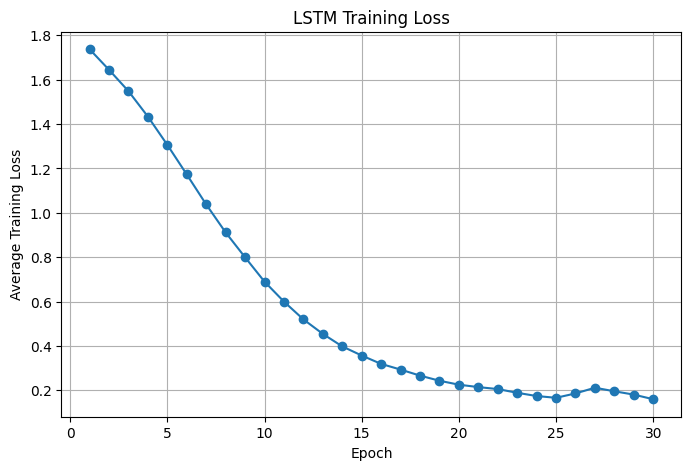

Test Accuracy: 0.9241

--- Fold 4/5 ---
Epoch [1/30], Loss: 1.7667
Epoch [2/30], Loss: 1.6707
Epoch [3/30], Loss: 1.5738
Epoch [4/30], Loss: 1.4713
Epoch [5/30], Loss: 1.3506
Epoch [6/30], Loss: 1.2133
Epoch [7/30], Loss: 1.0772
Epoch [8/30], Loss: 0.9508
Epoch [9/30], Loss: 0.8419
Epoch [10/30], Loss: 0.7451
Epoch [11/30], Loss: 0.6575
Epoch [12/30], Loss: 0.5871
Epoch [13/30], Loss: 0.5245
Epoch [14/30], Loss: 0.4740
Epoch [15/30], Loss: 0.4311
Epoch [16/30], Loss: 0.3945
Epoch [17/30], Loss: 0.3639
Epoch [18/30], Loss: 0.3343
Epoch [19/30], Loss: 0.3079
Epoch [20/30], Loss: 0.2891
Epoch [21/30], Loss: 0.2704
Epoch [22/30], Loss: 0.2562
Epoch [23/30], Loss: 0.2471
Epoch [24/30], Loss: 0.2288
Epoch [25/30], Loss: 0.2179
Epoch [26/30], Loss: 0.2011
Epoch [27/30], Loss: 0.2066
Epoch [28/30], Loss: 0.1987
Epoch [29/30], Loss: 0.1813
Epoch [30/30], Loss: 0.1739


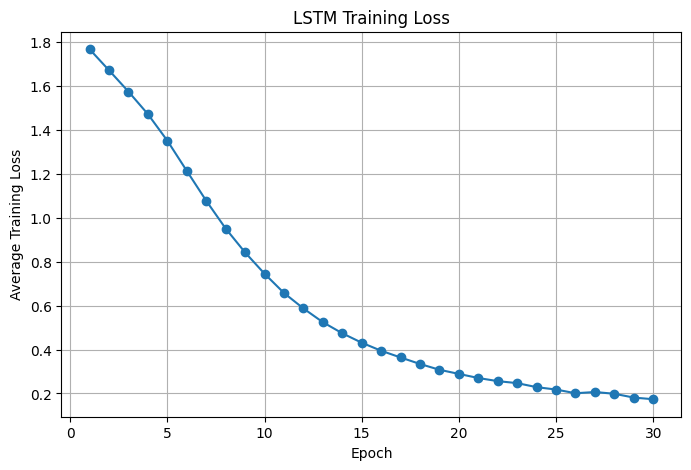

Test Accuracy: 0.9494

--- Fold 5/5 ---
Epoch [1/30], Loss: 1.7592
Epoch [2/30], Loss: 1.6418
Epoch [3/30], Loss: 1.5235
Epoch [4/30], Loss: 1.3902
Epoch [5/30], Loss: 1.2422
Epoch [6/30], Loss: 1.1056
Epoch [7/30], Loss: 0.9860
Epoch [8/30], Loss: 0.8819
Epoch [9/30], Loss: 0.7900
Epoch [10/30], Loss: 0.7059
Epoch [11/30], Loss: 0.6337
Epoch [12/30], Loss: 0.5737
Epoch [13/30], Loss: 0.5184
Epoch [14/30], Loss: 0.4729
Epoch [15/30], Loss: 0.4358
Epoch [16/30], Loss: 0.3998
Epoch [17/30], Loss: 0.3680
Epoch [18/30], Loss: 0.3417
Epoch [19/30], Loss: 0.3157
Epoch [20/30], Loss: 0.2903
Epoch [21/30], Loss: 0.2696
Epoch [22/30], Loss: 0.2617
Epoch [23/30], Loss: 0.2325
Epoch [24/30], Loss: 0.2199
Epoch [25/30], Loss: 0.2054
Epoch [26/30], Loss: 0.1933
Epoch [27/30], Loss: 0.1831
Epoch [28/30], Loss: 0.1664
Epoch [29/30], Loss: 0.1550
Epoch [30/30], Loss: 0.1476


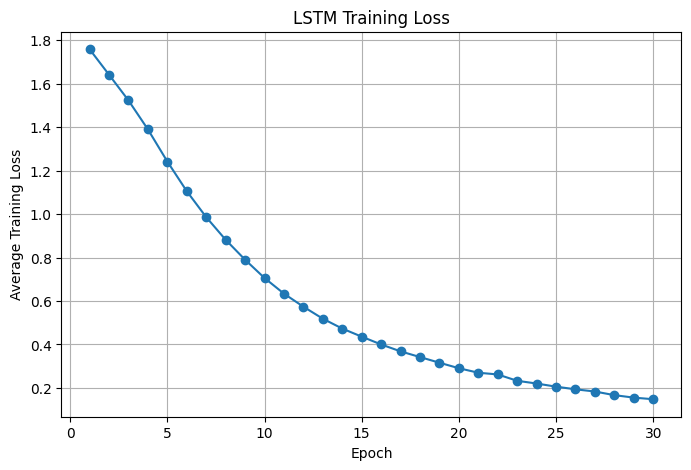

Test Accuracy: 0.9747

Average Accuracy across 5 folds: 0.9596


In [79]:
# NEU: 5-Fold Cross Validation

# Sequenzen erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)  # Labels 0-basiert

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/{5} ---")

    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]

    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Neues Modell für jeden Fold
    model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
    model.to(device)

    model.train_model(train_loader, epochs=30)

    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")